In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

**Data Transformations**

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation(degrees=(10, -10), fill=(0,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

**Dataset and Creating Train/Test Split**


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


**Dataloader Arguments & Test/Train Dataloaders**


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


**Data Statistics**

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0)
 - max: tensor(255)
torch.Size([128, 1, 28, 28])
torch.Size([128])


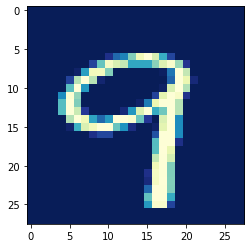

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = np.array(train.train_data)
#train_data = train.transform(train_data.numpy())
train_data = torch.from_numpy(train_data).long()

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
#print(' - mean:', torch.mean((train_data)))
#print(' - std:', torch.std(train_data))
#print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='YlGnBu_r')


**MORE**

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

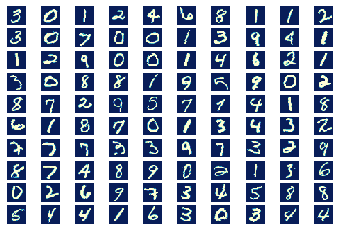

In [7]:
figure = plt.figure()
num_of_images = 100
for index in range(1, num_of_images + 1):
    plt.subplot(10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='YlGnBu_r')

**The model**

Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 7

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 5

        
        # OUTPUT BLOCK
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.1)
        ) # output_size = 5


        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5, 5), padding=0, bias=False),
            #nn.AvgPool2d(kernel_size=(5, 5),stride=None, padding=0)
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

**Model Params**

Can't emphasize on how important viewing Model Summary is. Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             720
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 16, 22, 22]           1,440
      BatchNorm2d-10           [-1, 16, 22, 22]              32
             ReLU-11           [-1, 16, 22, 22]               0
          Dropout-12           [-1, 16, 22, 22]               0
        MaxPool2d-13           [-1, 16, 11, 11]               0
           Conv2d-14            [-

**Training and Testing**

Looking at logs can be boring, so we'll introduce tqdm progressbar to get cooler logs.

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

**Let's Train and test our model**


In [100]:
import os

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.20613378286361694 Batch_id=468 Accuracy=88.88: 100%|██████████| 469/469 [00:13<00:00, 34.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0689, Accuracy: 9781/10000 (97.81%)

EPOCH: 1


Loss=0.12212122231721878 Batch_id=468 Accuracy=96.40: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0457, Accuracy: 9849/10000 (98.49%)

EPOCH: 2


Loss=0.10190918296575546 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9879/10000 (98.79%)

EPOCH: 3


Loss=0.06463112682104111 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.051427070051431656 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:14<00:00, 36.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.056183453649282455 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:14<00:00, 32.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9921/10000 (99.21%)

EPOCH: 6


Loss=0.05161593481898308 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.02457401715219021 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9915/10000 (99.15%)

EPOCH: 8


Loss=0.04787329211831093 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:14<00:00, 32.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.02692251093685627 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.08031976222991943 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.025975817814469337 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:14<00:00, 31.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.030236616730690002 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:14<00:00, 31.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.07689735293388367 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9942/10000 (99.42%)

EPOCH: 14


Loss=0.06793759763240814 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:15<00:00, 30.09it/s]



Test set: Average loss: 0.0227, Accuracy: 9928/10000 (99.28%)



***Implementing StepLR***

In [13]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    scheduler.step()
    print('Epoch:', epoch,'LR:', scheduler.get_lr())
    #print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/469 [00:00<?, ?it/s]

Epoch: 0 LR: [0.1]


Loss=0.16470789909362793 Batch_id=468 Accuracy=92.77: 100%|██████████| 469/469 [00:14<00:00, 32.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0549, Accuracy: 9825/10000 (98.25%)

Epoch: 1 LR: [0.1]


Loss=0.10522700101137161 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0376, Accuracy: 9874/10000 (98.74%)

Epoch: 2 LR: [0.1]


Loss=0.0910811498761177 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9853/10000 (98.53%)

Epoch: 3 LR: [0.1]


Loss=0.1167583093047142 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9893/10000 (98.93%)

Epoch: 4 LR: [0.1]


Loss=0.027042493224143982 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:14<00:00, 32.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9912/10000 (99.12%)

Epoch: 5 LR: [0.0010000000000000002]


Loss=0.015566562302410603 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9929/10000 (99.29%)

Epoch: 6 LR: [0.010000000000000002]


Loss=0.013725027441978455 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9919/10000 (99.19%)

Epoch: 7 LR: [0.010000000000000002]


Loss=0.021698346361517906 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9926/10000 (99.26%)

Epoch: 8 LR: [0.010000000000000002]


Loss=0.03608371689915657 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9927/10000 (99.27%)

Epoch: 9 LR: [0.010000000000000002]


Loss=0.13940776884555817 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9926/10000 (99.26%)

Epoch: 10 LR: [0.010000000000000002]


Loss=0.10942663997411728 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:13<00:00, 33.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

Epoch: 11 LR: [0.00010000000000000003]


Loss=0.08612561225891113 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

Epoch: 12 LR: [0.0010000000000000002]


Loss=0.04124652221798897 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:14<00:00, 32.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

Epoch: 13 LR: [0.0010000000000000002]


Loss=0.06126796081662178 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:13<00:00, 34.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

Epoch: 14 LR: [0.0010000000000000002]


Loss=0.007185021881014109 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]



Test set: Average loss: 0.0209, Accuracy: 9937/10000 (99.37%)



Text(0.5, 1.0, 'Test Accuracy')

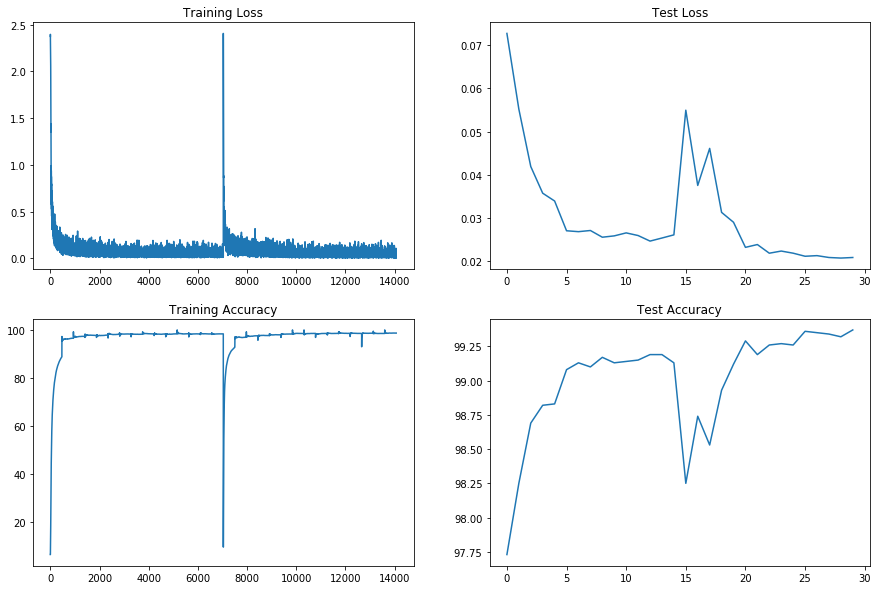

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")